In [98]:
def plot(data):
    figure, axis = plt.subplots(2, 3)

    axis[0][0].plot(data.cost)
    axis[0][0].set_title("cost transport")
    #axis[0].set_ylim((0, 2))

    axis[0][1].plot(data.time_child)
    axis[0][1].set_title("time to find a child")
    #axis[1].set_ylim((0, 0.01))

    axis[0][2].plot(data.time_model)
    axis[0][2].set_title("LP time")
    #axis[2].set_ylim((0, 0.5))

    axis[1][0].plot(data.n_children)
    axis[1][0].set_title("number sites")

    axis[1][1].boxplot(data.memory)
    axis[1][1].set_title("number of memory slot")

    #axis[1][2].plot(np.array(data.cost[:-1])-np.array(data.cost[1:]))
    #axis[1][2].set_title("improvements")
    
    axis[1][2].plot(data.n_best)
    axis[1][2].set_title("number best children")


    figure.set_size_inches(18.5, 10.5)

    plt.show()

    print(f"the final cost is {data.cost[-1]}")
    
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import scipy
import time
import itertools
import scipy
import cvxpy as cp
import random
import matplotlib
import math
import gurobipy as gp
from gurobipy import GRB

def create_array(orig_array, percentage):
    # Compute the number of unique rows we'll use
    num_rows = int(orig_array.shape[0] *percentage)
    
    # If num_rows is zero, we should at least select one row.
    num_rows = max(1, num_rows)
    
    # Randomly select 'num_rows' row indices without replacement
    unique_indices = np.random.choice(orig_array.shape[0], size=num_rows, replace=False)

    # Select the unique rows from the original array
    unique_rows = orig_array[unique_indices, :]
    
    # Now, we'll need to repeat these rows to fill the new array
    num_repeats = int(np.ceil(orig_array.shape[0] / float(num_rows)))

    # Repeat the unique rows to create a new array
    new_array = np.repeat(unique_rows, num_repeats, axis=0)
    
    # Make sure the new array has the same number of rows as the original array
    new_array = new_array[:orig_array.shape[0], :]
    
    return new_array

class Genetic_Algorithm:
    def __init__(self, img_list):
        
        
        self.N = img_list[0].shape[0]
        self.dim = len(img_list[0].shape)
        self.imgs = np.array([img.flatten() for img in img_list])
        self.b_eq = np.concatenate(self.imgs)
        self.non_zero_indices = []
        self.n_imgs = len(self.imgs)
       
        
        
         #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_model = []
        self.len_children = []
        self.n_children = []
        self.memory=[]
        self.n_best=[]
        
        start = time.time()
        print("initializing omega...")
        self.initialize_omega(add_diag=False)
        print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        print("initializing cost vector...")
        self.current_cost_vector = self.get_cost(self.active_indices)
        print("cost vector initialized in %5.3f. s" %(time.time()-start))
       
        start = time.time()
        print("initializing full model...")
        self.initialize_model()
        print("full model initialized in %5.3f. s" %(time.time()-start))

       
        
    def initialize_omega(self, add_diag=False):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        indices = np.zeros(self.n_imgs)
        omega = np.array(indices.copy())
        b = np.array([img[0] for img in self.imgs])

        current_gamma = [np.min(b)]
        while np.min(indices) < self.N**self.dim-1:
            gamma = np.min(b)
            b-=gamma
            low = np.where(b < 1e-9)[0]
            indices[low] +=1
            indices = np.clip(indices, a_min=0, a_max=self.N**self.dim-1)
            b[low] = self.imgs[low,indices[low].astype('int')]
            
            omega = np.vstack((omega,indices.copy()))
            current_gamma.append(gamma)
        
        self.current_gamma = np.array(current_gamma)
        self.active_indices = np.array(omega).astype('int')
        if add_diag:
            self.current_gamma = np.concatenate((self.current_gamma, np.zeros(self.N**self.dim)))
            self.active_indices = np.vstack((self.active_indices, np.repeat(np.arange(0,self.N**self.dim)[:, np.newaxis], self.n_imgs, axis=1)))
            
        
        
        
        
    def initialize_model(self):
        start = time.time()
        indices_row = np.array([])
        indices_col = np.array([])
        for i in range(self.n_imgs):
            for indices in range(self.N**self.dim):
                gamma_indices = np.where(self.active_indices.transpose()[i] == indices)[0]
                indices_row = np.concatenate((indices_row, gamma_indices))
                indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+i*(self.N**self.dim))))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( (self.N**self.dim)*self.n_imgs, len(self.active_indices)))
        
        self.m = gp.Model("model")
        self.m.Params.OutputFlag = True
        self.m.Params.UpdateMode = 1
        self.m.Params.LPWarmStart=2
        self.m.Params.Method=-1
        
        self.gamma = self.m.addMVar(shape=len(self.current_cost_vector), vtype=GRB.CONTINUOUS)
        #self.m.update()
        
        self.m.setObjective(self.current_cost_vector@self.gamma, GRB.MINIMIZE) 
        
        self.m.Params.FeasibilityTol = 1e-8
        
        
        self.m.addMConstr(A_eq, self.gamma, '=', self.b_eq)
        
    
        self.m.optimize()
        self.time_model.append(time.time()-start)
        self.cost.append(self.m.ObjVal)
        self.current_gamma = np.array(self.gamma.X)
        self.current_kantorovich = np.array(self.m.PI)
        self.constraints_RMP=A_eq
       
  

    def barycentric_distance(self, indices_list):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
       
        barycenter = np.sum(indices_list/self.N, axis=0)/self.n_imgs
        
        barycenter_cost = np.sum([np.sum((x - barycenter) ** 2, axis=0)/self.n_imgs for x in indices_list/self.N], axis=0)
      
        return barycenter_cost

    def get_cost(self, vector):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second
        indices_list = []
        for i in range(self.n_imgs):
            indices_list.append(np.array(np.unravel_index(vector.transpose()[i], tuple([self.N for i in range(self.dim)]))))
        cost_vector = self.barycentric_distance(np.array(indices_list))
        return cost_vector

    def compute_gain(self, cost, children):
        gain = np.sum([self.current_kantorovich[i*(self.N**self.dim):(i+1)*(self.N**self.dim)][children.transpose()[i]] for i in range(self.n_imgs)], axis=0)-cost
        return gain

    def find_best_child(self):
        parent = self.non_zero_indices.copy().transpose()
       
        parent = create_array(parent, self.parent_to_children)
       
        index = random.sample(range(0, self.n_imgs), self.parent_changed)
        parent[index] = np.random.randint(0, self.N**self.dim, size=len(parent[1]))
        
        children = parent.copy().transpose()
        
        gain = self.compute_gain(self.get_cost(children), children)
        
        best_children = children[np.where(gain > 0)[0]]
       
        #now take the best turnover_rate% or just some random turnover_rate
        if not self.random_selection:                  
            best_children = children[np.argsort(gain)[-int(best_children.shape[0]*self.turnover_rate):]]
        else:
            chosen_children = np.random.choice(best_children.shape[0], size=int(best_children.shape[0]*self.turnover_rate), replace=False)
            best_children = best_children[chosen_children]
        
        if self.add_neighbours:
            for i in self.neighbours:
                parent[index] = np.clip(self.non_zero_indices.copy().transpose()[index]+i, 0, self.N**2-1)
                children = parent.copy().transpose()
                gain = self.compute_gain(self.get_cost(children), children)
                best_children = np.vstack((best_children,children[np.where(gain > 0)[0]]))

            
       
        return best_children

    
    def run(self, max_iter, max_sample, max_runtime, beta, turnover_rate, parent_to_children, random_selection, parent_changed, add_neighbours, radius):
        
        self.beta = beta
        self.turnover_rate = turnover_rate
        self.parent_to_children = parent_to_children
        self.random_selection = random_selection
        self.parent_changed = parent_changed
        self.add_neighbours = add_neighbours
        self.radius=radius
        self.neighbours= []
        self.iter=0
        for i in range(int(-self.N**2/2),int(self.N**2/2)):
                xx = i % self.N*np.sign(i)
                yy = int(i / self.N)
                mask = (xx)**2 + (yy)**2 < self.radius**2
                if not mask or i==0: continue
                self.neighbours.append(i)
        
        start_runtime = time.time()
        n_memory=0
        for _ in tqdm(range(max_iter)):
            if time.time() - start_runtime > max_runtime:
                break
            start_iter = time.time()
            self.non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            sample = 0
            #divide the non zero indices into chunks of size chunk_size
            best_children = self.find_best_child()
            while best_children.shape[0] < 2 and sample < max_sample:
                sample += 1
                best_children = self.find_best_child()
            if best_children.shape[0]<2:
                print("done?")
                break
            self.iter+=1
            self.children_sampled.append(sample)
            self.n_children.append(self.active_indices.shape[0])
            self.n_best.append(best_children.shape[0])
            
            
            
            self.current_cost_vector = np.append(self.current_cost_vector, self.get_cost(best_children))
            self.cost_children = self.get_cost(best_children)
            self.current_gamma = np.append(self.current_gamma, np.zeros(best_children.shape[0]))
            
            self.active_indices = np.vstack((self.active_indices, best_children))
            
            idx = best_children.copy().transpose()
            shift = np.array([i*(self.N**self.dim) for i in range(self.n_imgs)]).reshape(-1,1)
            idx = (idx+shift).transpose()
            reshaped_arr = idx.reshape(-1).copy()
            #print(idx.shape)

           

            # Create an array for the second element in each tuple
            second_elements = np.repeat(np.arange(len(best_children)), self.n_imgs)

            # Stack the two arrays
            stacked_arr = np.vstack((reshaped_arr, second_elements))
          
            A_children = sp.csr_matrix((np.ones(len(best_children)*self.n_imgs), (stacked_arr[0], stacked_arr[1])), shape=((self.N**self.dim)*self.n_imgs, len(best_children)))
            self.constraints_RMP = sp.hstack((self.constraints_RMP, A_children))
            n_memory+=1
            
            self.time_child.append(time.time() - start_iter)
            
            
            if self.active_indices.shape[0] > int(self.beta*((self.N**self.dim)*self.n_imgs)):
                self.memory.append(n_memory)
                n_memory=0
                if self.beta>3:
                    remove_value = self.beta-1
                else:
                    remove_value = 1
                zero_indices = np.where(self.current_gamma == 0)[0][:int(remove_value*(self.N**self.dim)*self.n_imgs)]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.iter=0
                self.initialize_model()
                continue
            
            start = time.time()
            #self.m = gp.Model("model")
            #self.new_gamma=self.m.addMVar(shape=best_children.shape[0], vtype=GRB.CONTINUOUS)
            #self.expr.addTerms(self.current_cost_vector[-best_children.shape[0]:], self.new_gamma.tolist())
            
            
            
            #for i in range(self.iter):
            #    print(self.current_cost_vector[self.idx_child[i]:self.idx_child[i+1]])
            #self.m.setObjective(self.expr, GRB.MINIMIZE)
            if self.time_model[-1] > 3:
                self.solve_model()
                continue
                
            constr = self.m.getConstrs()
            
            #print(A_children[0])
            #print([stacked_arr[0][j] for j in range(0,self.n_imgs)])
            #break
            
            for i in range(len(best_children)):
                self.m.addVar(obj=self.cost_children[i],  vtype=GRB.CONTINUOUS,
                              column=gp.Column([1]*self.n_imgs,
                                               [constr[j] for j in idx[i]]))
                #self.m.update()
            
            
            #self.m.getVars().PStart = self.current_gamma
            #constr.DStart = self.current_kantorovich
            #self.m.reset()
            self.m.optimize()
           
            self.cost.append(self.m.ObjVal)
            self.time_model.append(time.time()-start)
            self.current_gamma = np.array(self.m.getAttr("X", self.m.getVars())).copy()
            self.current_kantorovich = np.array(self.m.PI).copy()
            
    def solve_model(self):
        start = time.time()
        self.m = gp.Model("model")
        self.gamma = self.m.addMVar(shape=len(self.current_cost_vector), vtype=GRB.CONTINUOUS, name="gamma")
        self.m.setObjective(self.current_cost_vector @ self.gamma, GRB.MINIMIZE)
        self.m.Params.OutputFlag = False
        
        self.m.Params.FeasibilityTol = 1e-8
        self.constraints = self.m.addConstr(self.constraints_RMP @ self.gamma == self.b_eq, name="eq_c")
        self.m.Params.LPWarmStart=2
        self.gamma.PStart = self.current_gamma
        self.constraints.DStart = self.current_kantorovich
        self.m.update
        self.m.optimize()
        primal_solution = np.array(self.gamma.X)
        dual_solution = np.array(self.m.PI)
        self.cost.append(self.m.ObjVal)
        self.time_model.append(time.time()-start)
        self.current_gamma = primal_solution
        self.current_kantorovich = dual_solution
        #print(dual_solution.shape)
            
         
    

    def get_mean(self, par):
        
        indices = np.array([[np.unravel_index(self.active_indices.transpose()[i], (self.N, self.N))[j] for i in range(self.n_imgs)] for j in range(2)]) 
        indices = indices.transpose((1,0,2))
        mean = [np.sum([par[i]*indices[i][j] for i in range(self.n_imgs)], axis=0).astype('int') for j in range(2)]        
        mean = np.ravel_multi_index(mean, (self.N, self.N))
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(self.N ** 2, self.N ** 2))
        return 1-gamma.todense().transpose().dot(self.imgs[0]).reshape(self.N, self.N)

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        if self.n_imgs==2:
            plt.close()
            fig, axs = plt.subplots(2, 6)
            axs[0][0].imshow(self.get_mean((1,0)), cmap='gray')
            axs[0][1].imshow(self.get_mean((0.95,0.05)), cmap='gray')
            axs[0][2].imshow(self.get_mean((0.9,0.1)), cmap='gray')
            axs[0][3].imshow(self.get_mean((0.8,0.2)), cmap='gray')
            axs[0][4].imshow(self.get_mean((0.7,0.3)), cmap='gray')
            axs[0][5].imshow(self.get_mean((0.6,0.4)), cmap='gray')
            axs[1][0].imshow(self.get_mean((0.5,0.5)), cmap='gray')
            axs[1][1].imshow(self.get_mean((0.4,0.6)), cmap='gray')
            axs[1][2].imshow(self.get_mean((0.3,0.7)), cmap='gray')
            axs[1][3].imshow(self.get_mean((0.2,0.8)), cmap='gray')
            axs[1][4].imshow(self.get_mean((0.1,0.9)), cmap='gray')
            axs[1][5].imshow(self.get_mean((0,1)), cmap='gray')
            plt.show()
        if self.n_imgs==3:
            plt.close()
            fig, axs = plt.subplots(4, 4)
            axs[0][0].imshow(self.get_mean((1,0,0)), cmap='gray')
            axs[0][1].imshow(self.get_mean((0.67,0.33,0)), cmap='gray')
            axs[0][2].imshow(self.get_mean((0.37,0.63,0)), cmap='gray')
            axs[0][3].imshow(self.get_mean((0,1,0)), cmap='gray')
            axs[1][0].imshow(self.get_mean((0.67,0,0.33)), cmap='gray')
            axs[1][1].imshow(self.get_mean((0.5,0.25,0.25)), cmap='gray')
            axs[1][2].imshow(self.get_mean((0.25,0.5,0.25)), cmap='gray')
            axs[2][0].imshow(self.get_mean((0.33,0,0.67)), cmap='gray')
            axs[2][1].imshow(self.get_mean((0.25,0.25,0.5)), cmap='gray')
            axs[3][0].imshow(self.get_mean((0,0,1)), cmap='gray')  
            plt.show()
        if self.n_imgs>3:
            plt.close()
            fig, axs =plt.subplots(1,self.n_imgs+1)
            for i in range(self.n_imgs):
                axs[i].imshow(1-self.imgs[i].reshape(self.N,self.N), cmap='gray')
            axs[self.n_imgs].imshow(self.get_mean(tuple([1/self.n_imgs])*self.n_imgs), cmap='gray')
            plt.show()
            
    def save(self):
        matplotlib.image.imsave('barycenter.png', self.get_mean(0.5), cmap='Greys')

 

In [99]:

path_img1 = "dolphin_64.jpg"
path_img2 = "bird_64.jpg"
path_img3 = "star_64.jpg"
path_img4 = "flower_64.jpg"

dim=128 
n_imgs = 2
#copies: (32,(2,3,4,8,16,24)), (64,(2,3,4,8)), (128,(2,3,4)), 
#14 total tests (dim, n_imgs)

#paths = [f"L/L{i}.jpg" for i in range(1,8)]
#paths = [path_img1,path_img2, path_img3]
#img_list = [np.array(Image.open(path).convert('L')) for path in paths]
img_list = [np.random.random((dim,dim)) for i in range(n_imgs)]
#img_list = [1-img/255 for img in img_list]
img_list = [(img/np.sum(img))*img.shape[0] for img in img_list]


In [100]:
ga = Genetic_Algorithm(img_list)

initializing omega...
omega initialized in 1.077. s
initializing cost vector...
cost vector initialized in 0.001. s
initializing full model...
Set parameter LPWarmStart to value 2
Set parameter FeasibilityTol to value 1e-08
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 32768 rows, 32767 columns and 65534 nonzeros
Model fingerprint: 0x0daef773
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-07, 2e-02]
Presolve removed 32768 rows and 32767 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1095229e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.02 work units)
Optimal objective  5.109522854e+00
full model initialized in 2.007

In [101]:
turnover_rate = 1 #0.001, 0.01, 0.1, 0.5 , 1 -->5
beta = 6 #1.1, 1.5,2, 2.5, 5 ---> 5
#beta*support + t_r*good_children = k
#we try beta = 3 - t_r/5?

#beta is the memory
#turnover rate is % of children we take
#if we increase turnover rate, we cannot have a too big memory (or it will slow down)
#but also it cannot be too little (or we will restart at every iteration)

parent_to_children = 1 #1, 0.1, 0.01, 0.001 --->4
#ration between parents and their children
#we select p_c*n_active_set parents and approximately 1/p_c children per parent

random_selection = False #true, false ---> 2
#if True, we don't take the top t_r children but just some random

parent_changed = 1 #--->1
#it has to be lower than n_imgs, it's the number of parents that will be randomized (become children)

add_neighbours = False
radius = 2


#idea: if the image are similar then neighbour is a good idea


#claim
#turnover_rate+beta is indipendent from p_c+random_selection+parent_changed

#1st test: dim+n_imgs+turnover_rate+beta = 14*5*5 tests for n min each
#2nd test: dim+n_imgs+p_c+random_selection = 14*4*2 tests for k iteration each


In [102]:
ga.run(max_iter=20000, max_sample=30, max_runtime=60, beta=beta, turnover_rate=turnover_rate, parent_to_children=parent_to_children, random_selection=random_selection, parent_changed=parent_changed, add_neighbours=add_neighbours, radius=radius)

  0%|                                                 | 0/20000 [00:00<?, ?it/s]

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 32768 rows, 48706 columns and 97412 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 4e-01]
  Bounds range     [5e+04, 6e+04]
  RHS range        [2e-07, 2e-02]
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.01 work units)
Infeasible model


  0%|                                                 | 0/20000 [00:00<?, ?it/s]


AttributeError: Unable to retrieve attribute 'ObjVal'

In [68]:
ga.run(max_iter=20000, max_sample=30, max_runtime=60, beta=beta, turnover_rate=turnover_rate, parent_to_children=parent_to_children, random_selection=random_selection, parent_changed=parent_changed, add_neighbours=add_neighbours, radius=radius)

  0%|                                      | 65/20000 [01:01<5:11:59,  1.06it/s]


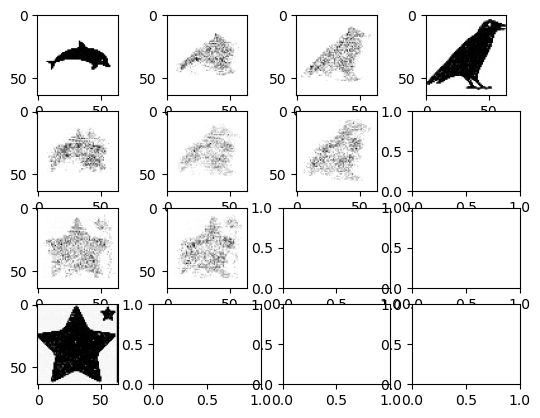

In [57]:
ga.plot()

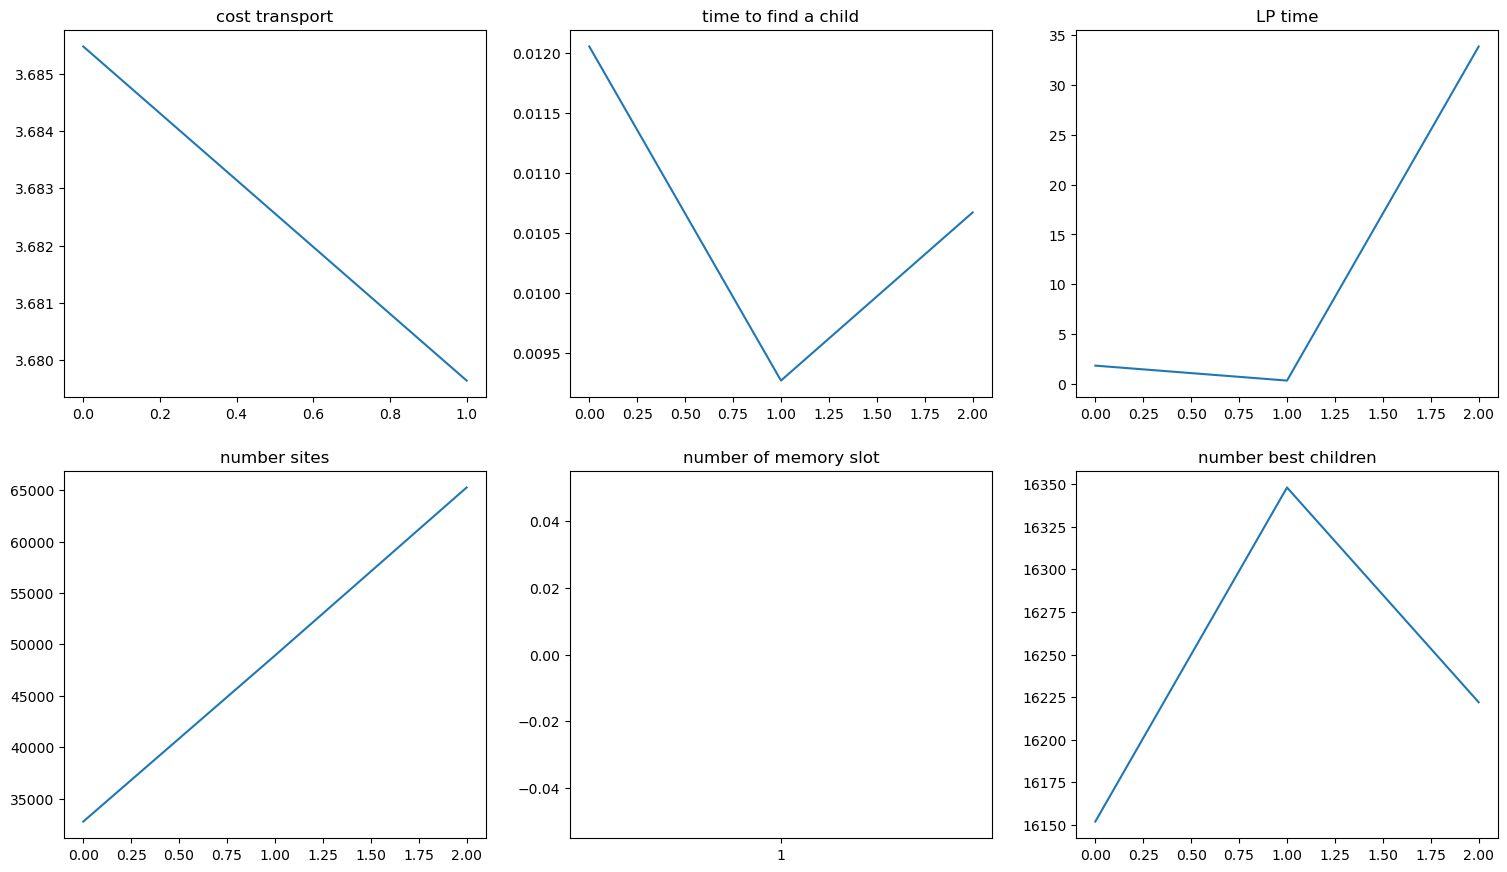

the final cost is inf


In [80]:
plot(ga)

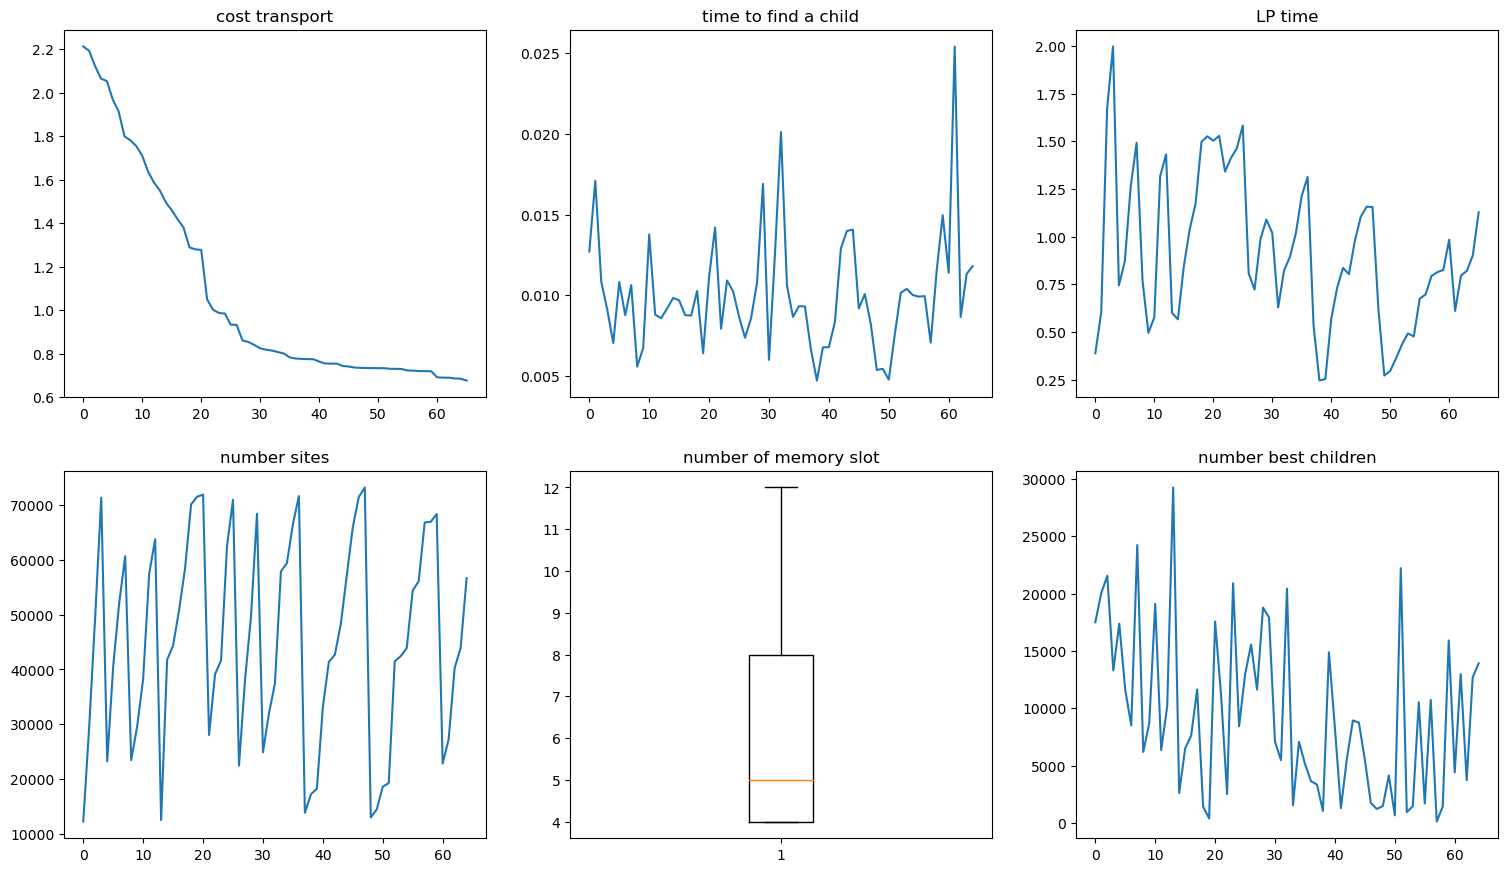

the final cost is 0.6763547927431246


In [69]:
plot(ga)

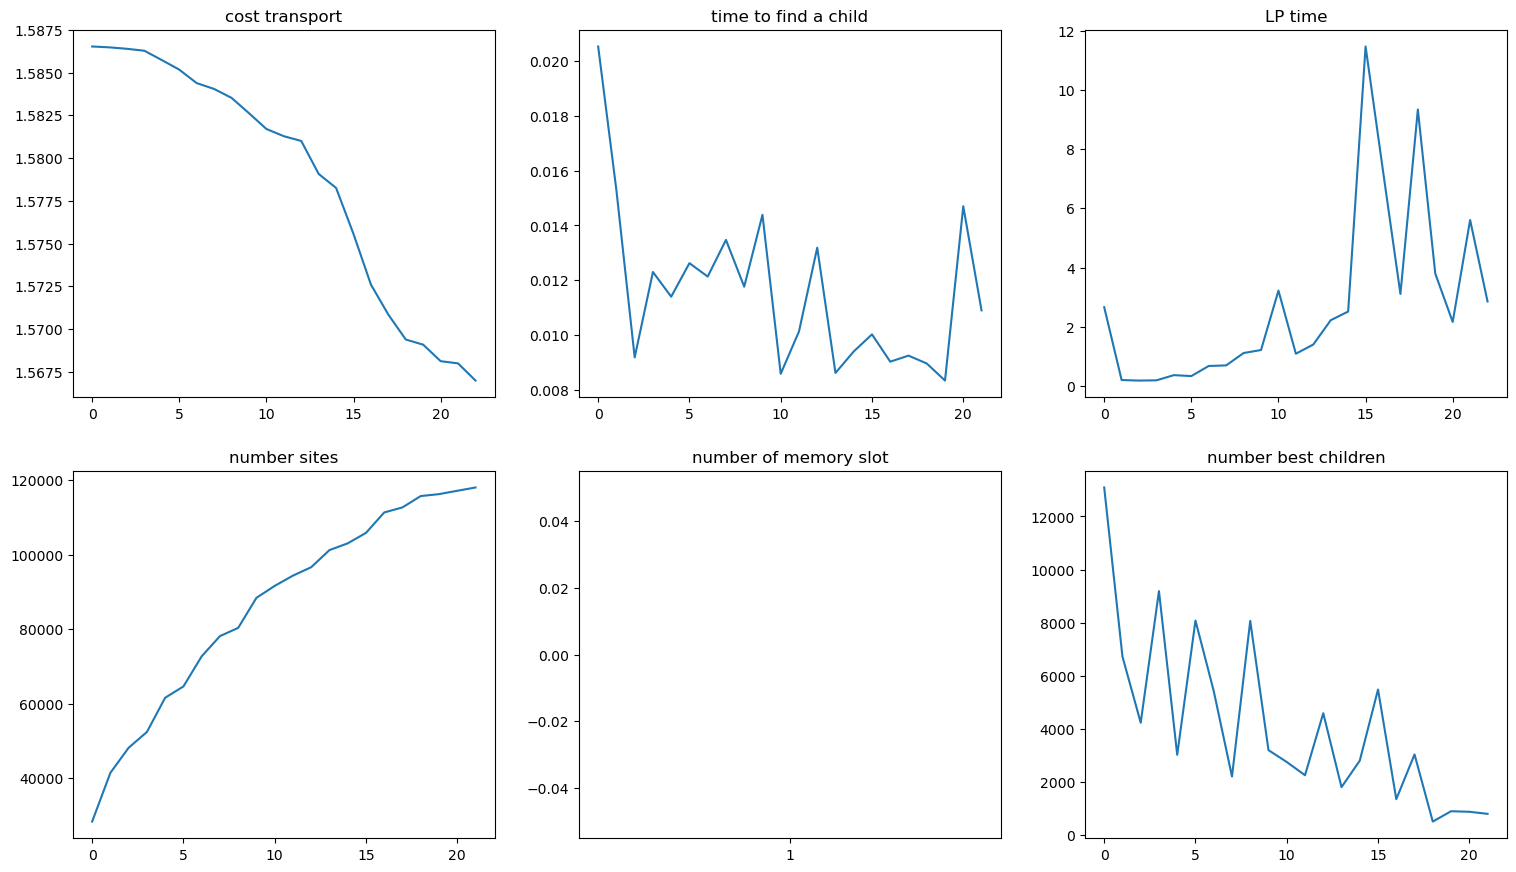

the final cost is 1.56698205082313


In [20]:
plot(ga)

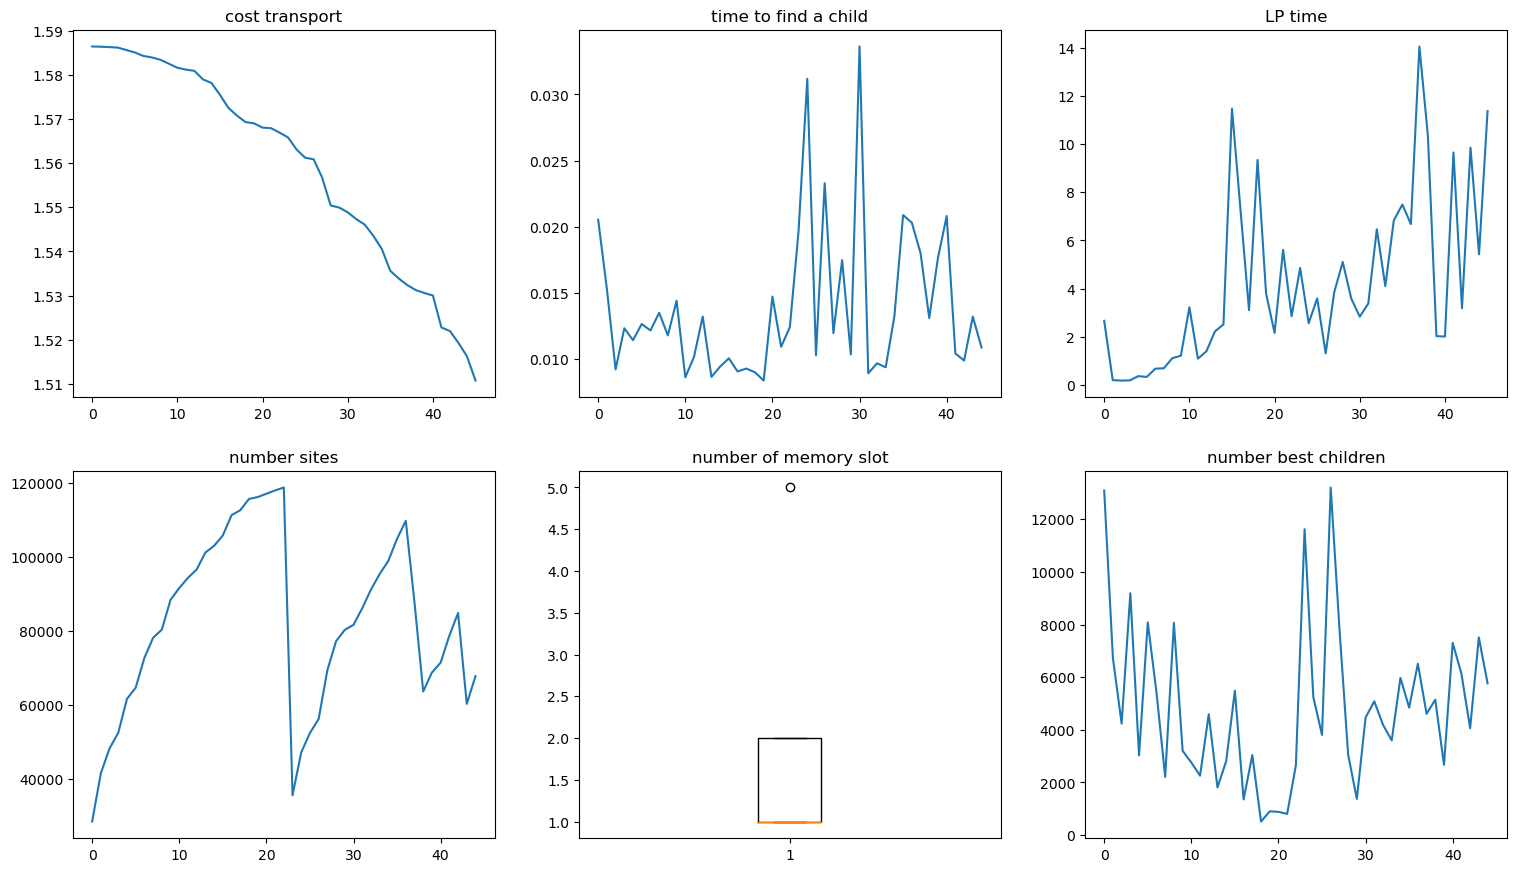

the final cost is 1.5106950288366863


In [26]:
plot(ga)

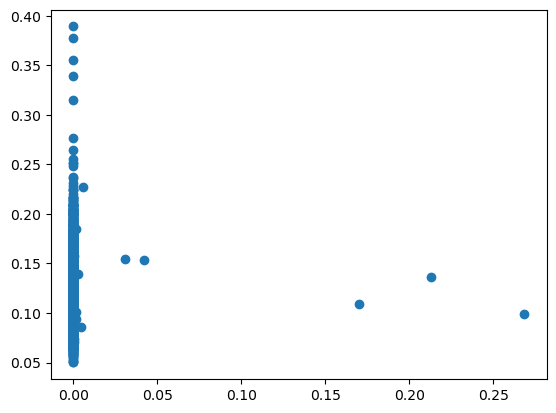

In [130]:
plt.scatter(np.array(ga.cost[:-1])-np.array(ga.cost[1:]), ga.time_model[1:])